51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Found 2691 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Epoch 1/60


c:\Users\darkk\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8121 - loss: 0.3569 - val_accuracy: 0.9857 - val_loss: 0.0578
Epoch 2/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.9408 - loss: 0.1505 - val_accuracy: 0.9714 - val_loss: 0.1085
Epoch 3/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.9707 - loss: 0.0815 - val_accuracy: 0.9905 - val_loss: 0.0208
Epoch 4/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.9740 - loss: 0.0808 - val_accuracy: 0.9714 - val_loss: 0.0661
Epoch 5/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.9753 - loss: 0.0613 - val_accuracy: 0.9905 - val_loss: 0.0420
Epoch 6/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.9756 - loss: 0.0586 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 7/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 279s 3s/step - accuracy: 0.9748 - loss: 0.0662 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 8/60
85/85 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.9844 - loss: 0.0476 - val_accuracy: 0.9952 - val_loss: 0.

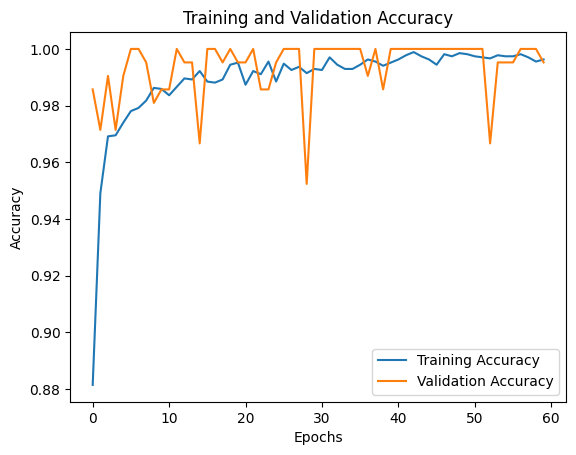

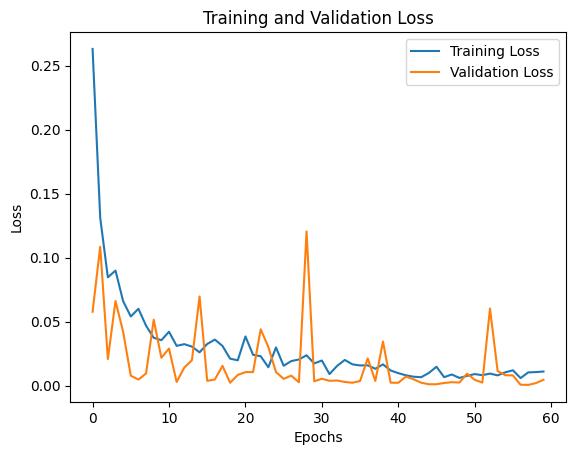

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9913 - loss: 0.0214
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step
Test Accuracy: 0.9904761910438538
Test Loss: 0.0286417193710804
Test Precision: 0.9714285714285714
Test Recall: 0.9714285714285714
Test F1 Score: 0.9714285714285714


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, Concatenate, GlobalAveragePooling2D, GlobalMaxPooling2D, Multiply, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.layers import Reshape

def cbam_block(input_feature, ratio=8):
    # Channel Attention Module
    channel_avg = GlobalAveragePooling2D()(input_feature)
    channel_max = GlobalMaxPooling2D()(input_feature)
    channel_concat = Concatenate(axis=-1)([channel_avg, channel_max])
    channel_dense_1 = Dense(units=input_feature.shape // ratio, activation='relu')(channel_concat)
    channel_dense_2 = Dense(units=input_feature.shape, kernel_initializer='relu')(channel_dense_1)
    channel_activation = Activation('sigmoid')(channel_dense_2)
    channel_attention = Multiply()([input_feature, channel_activation])

    # Spatial Attention Module
    spatial_avg = GlobalAveragePooling2D()(channel_attention)
    spatial_max = GlobalMaxPooling2D()(channel_attention)
    spatial_concat = Concatenate(axis=-1)([spatial_avg, spatial_max])
    spatial_attention = Reshape((1, 1, input_feature.shape[-1]*2))(spatial_concat)
    spatial_attention = Conv2D(filters=1, kernel_size=(7, 7), strides=(1, 1), padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(spatial_attention)
    spatial_attention = Multiply()([channel_attention, spatial_attention])

    return spatial_attention


# Load pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add CBAM blocks to the model
inputs = base_model.input
x = base_model.output
x = cbam_block(x)  
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define paths to dataset directories
train_dir = r"C:\Users\darkk\OneDrive\Desktop\flask\dataset\train"
validation_dir = r"C:\Users\darkk\OneDrive\Desktop\flask\dataset\validation"
test_dir = r"C:\Users\darkk\OneDrive\Desktop\flask\dataset\test"

# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)  

# Create data generators for each dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',  # Assuming binary classification
    shuffle=False  
)


optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Train the model and store the history
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator
)

import matplotlib.pyplot as plt
# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)

# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert predictions to binary labels
binary_predictions = np.where(predictions > 0.5, 1, 0)

# Get the true labels
true_labels = test_generator.classes

# Compute metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)

print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define parameters for data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Path to the directory containing your dataset
train_data_dir = r'C:\Users\darkk\OneDrive\Desktop\flask\dataset\train'

# Generate augmented data and save it to the directory
batch_size = 32
augmented_data_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),  # Set target size of images
    batch_size=batch_size,
    class_mode='binary',  # Set class mode based on your problem
    save_to_dir=r'C:\Users\darkk\OneDrive\Desktop\flask\Data',  # Directory to save augmented images
    save_prefix='aug',
    save_format='jpeg')

# Specify the number of batches you want to generate (e.g., for a fixed number of augmented images)
num_batches = 5  # Adjust as needed

# 
# Generate augmented images and save them to the directory
for i in range(num_batches):
    batch = next(augmented_data_generator)

print("Augmented images generated successfully.")

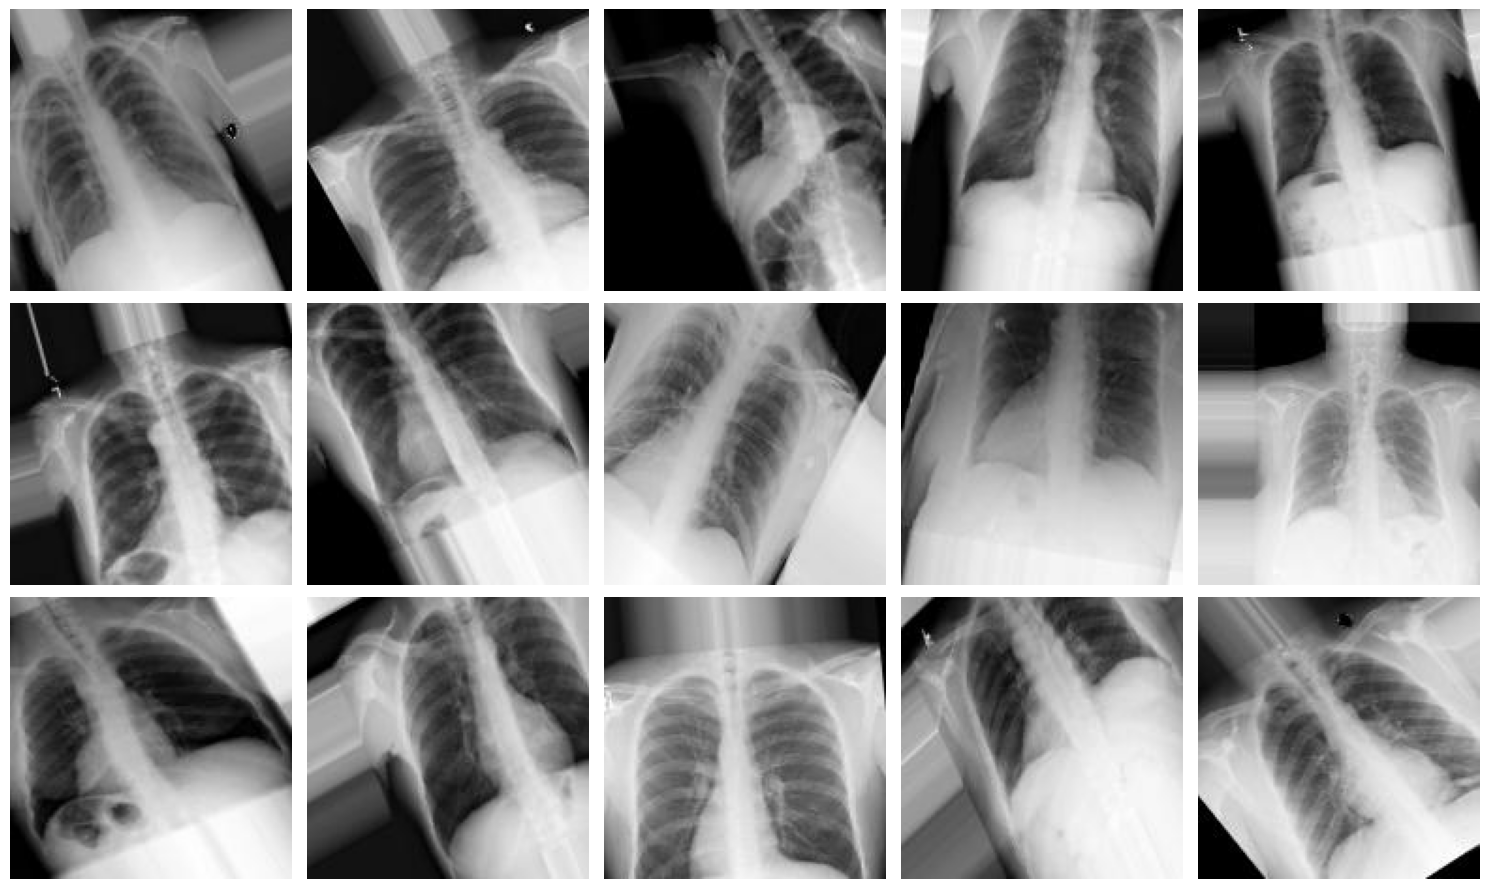

In [21]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_images(directory, num_images=15, cols=5):
    # Get the list of files in the directory
    files = os.listdir(directory)
    
    # Filter out non-image files
    image_files = [file for file in files if file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))]
    
    # Ensure we have enough images to display
    num_images = min(num_images, len(image_files))
    
    # Calculate the number of rows required
    rows = (num_images + cols - 1) // cols
    
    # Create subplots with the specified number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=(15 , 3 * rows))
    
    # Iterate through the image files and display them
    for i, image_file in enumerate(image_files[:num_images]):
        # Calculate the row and column index for the current image
        row_idx = i // cols
        col_idx = i % cols
        
        # Construct the path to the image file
        image_path = os.path.join(directory, image_file)
        
        # Load and display the image
        img = mpimg.imread(image_path)
        ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]
        ax.imshow(img)
        ax.axis('off')  # Turn off axis
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example usage
directory_path = r'C:\Users\darkk\OneDrive\Desktop\flask\Data'
visualize_images(directory_path, num_images=15, cols=5)
